In [47]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import datetime
import csv
import pandas as pd
import re

In [26]:
pip install yahoofinancials

In [27]:
pip install yfinance

In [2]:
# Constants
News_URL = "https://www.prnewswire.com/news-releases/news-releases-list/?"
#News_URL = "https://www.prnewswire.com/news-releases/news-releases-list/?month=11&day=24&year=2021&hour=00&page=1&pagesize=100"

Total_Days = 7 #Number of days to fetch
StockIndustry_Search = 'NYSE'
StockSymbol_Required = 2

In [3]:
# Global Variables
arr_Date = []
arr_newsTitle = []
arr_newsPara = []

In [4]:
# Date for extracting webpage
currentDate = datetime.datetime.now()
tempDate = currentDate

In [5]:
def prepare_URL(dayToFetch) -> str:
   urlByDay = News_URL + 'month=' + str(currentDate.month) + '&day=' + str(dayToFetch) + '&year=' + str(currentDate.year) + '&hour=00&page=1&pagesize=100'
   return urlByDay

In [6]:
def parse_News(forDay):
  url = prepare_URL(forDay)
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")

  # to extract main layout content
  main = soup.find_all('main',class_='headline-listing')

  for elements in main:
    lstContainer = elements.find_all('section',class_='container')
    for mainHead in lstContainer:
      row = mainHead.find_all('div',class_='row')
      for mainCol in row:
        rowList = mainCol.find_all('div',class_='col-md-8 col-sm-8 card-list card-list-hr')
        for newsCard in rowList:
          newsLst = newsCard.find_all('a',class_='newsreleaseconsolidatelink')
          for content in newsLst:
            small = content.h3.small.text
            content.h3.small.decompose()
            h3 = content.h3.text.replace("\n", "")
            p =  content.p.text
            arr_Date.append(small)
            arr_newsTitle.append(h3)
            arr_newsPara.append(p)

In [7]:
#Fetch & Parse data of last week
i = 0
while i < Total_Days:
  parse_News(currentDate.day - i)
  i = i + 1

In [8]:
# Write data to csv
dictNews = {'Date': arr_Date, 'Title': arr_newsTitle, 'Content': arr_newsPara}
df = pd.DataFrame(dictNews)
df.to_csv('newsData.csv')

df.head()

,Date,Title,Content
0,19:32 ET,Jelly Jim Positioned as One of the Leading Nut...,"Jelly Jim, a leader in the nutraceutical space..."
1,19:31 ET,mCloud Announces Closing of USD$9.5 Million Un...,"CALGARY, AB, Nov. 29, 2021 /PRNewswire/ - mClo..."
2,19:30 ET,Sound Generations Notifies its Clients and Oth...,"Out of an abundance of caution, Sound Generati..."
3,19:30 ET,Complex Fertilizers Market to Record a CAGR of...,The complex fertilizers market is set to grow ...
4,19:28 ET,URGENT: The M&A Firm is Investigating the Merg...,"Juan Monteverde, founder and managing partner ..."


In [31]:
#Search stock symbols of given industry

searchString = StockIndustry_Search + ': ([a-zA-Z]+)'
df_stockSymbols = df['Content'].str.extract(searchString, expand=False)
print(StockIndustry_Search)
# Dropping the duplicates 
df_stockSymbols = df_stockSymbols.drop_duplicates()

# Dropping the missing values.
df_stockSymbols = df_stockSymbols.dropna() 

NYSE


In [82]:
df_stock_list = df_stockSymbols
print(df_stock_list)

30      FTK
31      IVZ
32      ROG
46      ENB
56      SYF
70      EPC
78      MCD
79     KORE
84      AJG
86      KAR
137    CPLG
182     BMO
185     CRM
191    YEXT
195     AWF
197     AEM
277    SNAP
284    HRTG
405    CHGG
408    GOTU
409    AMPY
421     SLI
423    FICO
426    ONTF
429     RDW
434    OSCR
436    FTCH
438     OSH
439      DM
441    BKKT
444     ZME
447    HMLP
448     DNA
452     GWH
455    LSPD
492     BTG
556     BMA
567     KBR
570     LTH
582    ZEPP
591      CO
596      SM
628      EC
636     ACN
639     ROK
667    MATX
685      CP
Name: Content, dtype: object


In [83]:
from random import randint


sample_pick = (df_stock_list.sample(2))

In [84]:
stock_list  = sample_pick.to_string(index=False)
print(type(stock_list))

random_pick = stock_list.split()
print(random_pick)

<class 'str'>
['CO', 'AMPY']


#Yahoo Finance API


In [85]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [97]:
stock_df = yf.download(random_pick, 
                      start='2019-01-01', 
                      end='2021-06-12', 
                      progress=False,
)
stock_df.head()

Adj Close       Close        High  ...   Low  Open        Volume        
                AMPY    CO  AMPY    CO  AMPY  ...    CO  AMPY    CO    AMPY      CO
Date                                          ...                                  
2019-01-02  6.673095  6.20  8.01  6.20  8.04  ...  6.14  7.38  6.36  180300  125500
2019-01-03  6.706419  6.12  8.05  6.12  8.41  ...  5.98  8.03  6.19  200400   86700
2019-01-04  6.973010  6.29  8.37  6.29  8.42  ...  6.01  8.25  6.14  194600  118000
2019-01-07  7.264593  6.17  8.72  6.17  8.90  ...  6.09  8.42  6.35  136500  214300
2019-01-08  7.031326  6.00  8.44  6.00  8.84  ...  5.91  8.84  6.16  109900  217900

[5 rows x 12 columns]

In [87]:
stock_df = yf.download(random_pick)

[*********************100%***********************]  2 of 2 completed


In [98]:
stock_list  = sample_pick.to_string(index=False)
print(type(stock_list))

random_pick = stock_list.split()
print(random_pick)

<class 'str'>
['CO', 'AMPY']


**Stock price comparison**

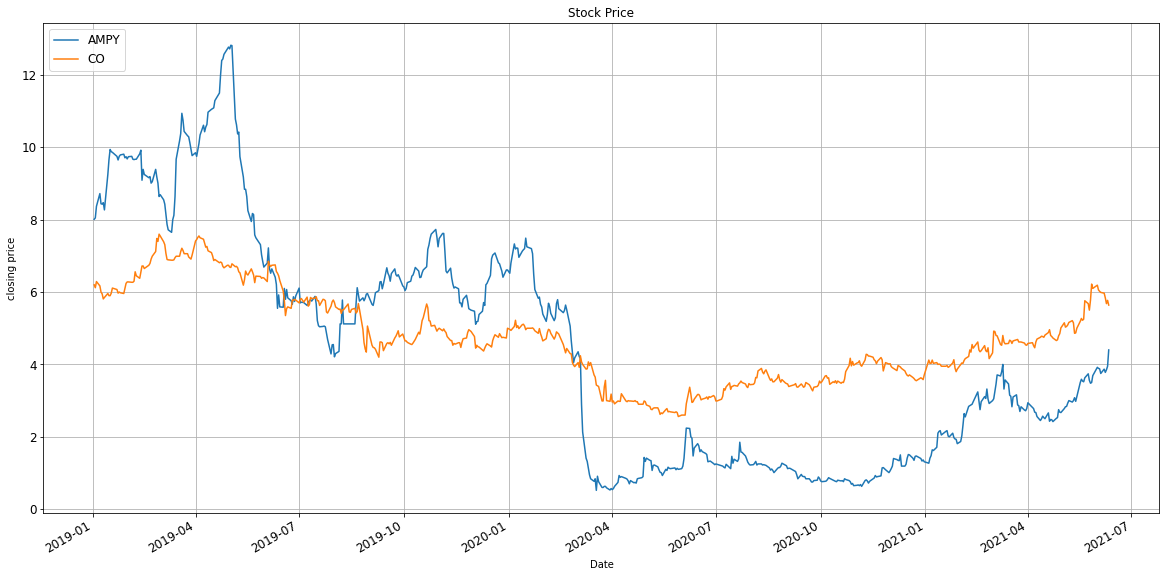

In [100]:

#ticker = yf.Ticker(random_pick[0])
#stock_df = ticker.history(period="5y")
#stock_df['Close'].plot(title=random_pick[0] + "'s stock price")

df = stock_df['Close']
#print(df)
ax = df.plot(title='Stock Price', fontsize=12, figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("closing price")

plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

**Stock's Volume Comparison**

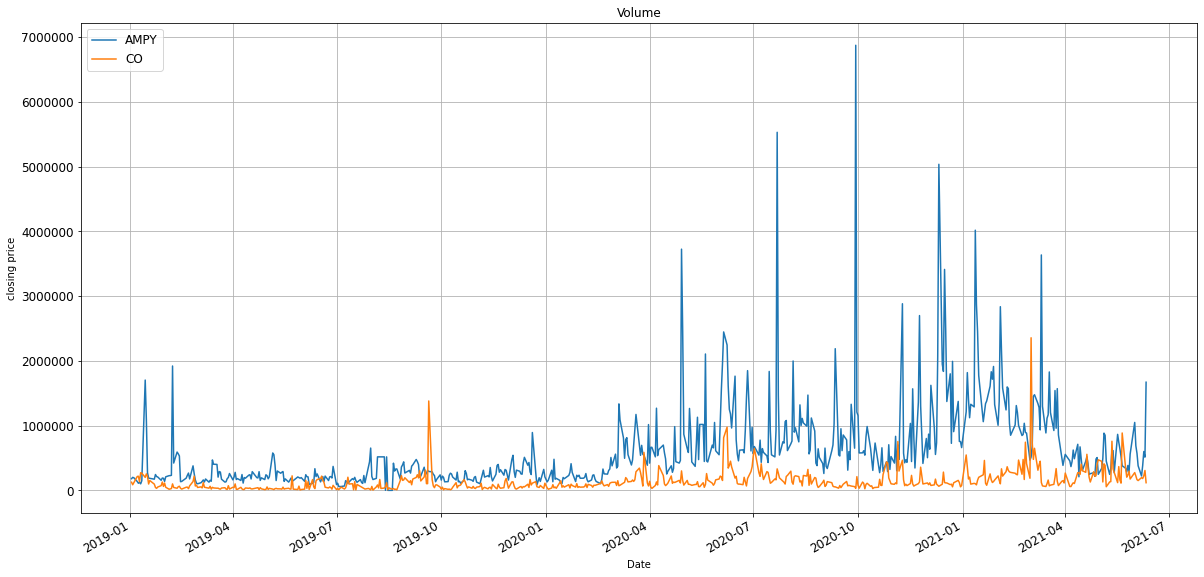

In [101]:
df = stock_df['Volume']
axis = df.plot(title='Volume', fontsize=12, figsize=(20, 10))
axis.set_xlabel("Date")
axis.set_ylabel("closing price")

# to remove scientific notation from matplotlib
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
yahoo_financials = YahooFinancials(random_pick)
data = yahoo_financials.get_historical_price_data(start_date='2019-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='weekly')
stock_df = pd.DataFrame(data[random_pick[0]]['prices'])
stock_df = stock_df.drop('date', axis=1).set_index('formatted_date')
stock_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-01-01,153.500000,145.210007,148.520004,151.380005,4049100,142.883041
2019-01-08,157.220001,150.240005,152.199997,156.199997,5566600,147.432495
2019-01-15,165.839996,153.940002,156.289993,164.750000,4728300,155.502594
2019-01-22,166.929993,159.850006,163.710007,163.250000,5451000,154.086746
2019-01-29,179.899994,166.309998,179.800003,169.679993,8498500,160.155838


In [ ]:
yahoo_financials = YahooFinancials(random_pick[1])
data=yahoo_financials.get_historical_price_data("2019-07-10", "2021-05-30", "monthly")
btc_df = pd.DataFrame(data[random_pick[1]]['prices'])
btc_df = btc_df.drop('date', axis=1).set_index('formatted_date')
btc_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-08-01,200.679993,184.229996,193.330002,198.169998,40805700,191.833435
2019-09-01,202.800003,187.279999,196.360001,192.350006,43457400,186.199554
2019-10-01,193.369995,181.970001,192.600006,185.419998,42679200,179.491150
2019-11-01,201.660004,185.479996,186.699997,201.160004,30349000,195.564499
2019-12-01,213.250000,196.470001,201.440002,210.570007,39647400,204.712738
